In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, GPT2LMHeadModel
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os, json, hashlib, time, math, torch
from torch.optim import AdamW

In [15]:
# Load the raw WikiText-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
print("Total rows (raw):", len(dataset))

# Basic text cleaning:
# - strip extra whitespace
# - collapse repeated spaces
dataset = dataset.map(lambda x: {"text": " ".join(x["text"].split()).strip()})

seen = set()
dataset = dataset.filter(lambda x: not (x["text"] in seen or seen.add(x["text"])))

# Remove empty lines (sometimes present after cleaning)
dataset = dataset.filter(lambda x: len(x["text"]) > 0)
print("Rows after clean+dedupe:", len(dataset))

# Split the cleaned dataset into training and validation subsets.
# This ensures we do not evaluate on the same data we train on.
splits = dataset.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Train rows:", len(train_ds), "| Val rows:", len(val_ds))


Total rows (raw): 36718
Rows after clean+dedupe: 21713
Train rows: 19541 | Val rows: 2172


In [16]:
# Load GPT-2 tokenizer (handles text → token IDs + attention masks)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# GPT-2 was not trained with a pad token, so we reuse its EOS token for padding.
# This prevents shape mismatches when batching sequences later.
tokenizer.pad_token = tokenizer.eos_token


def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        return_attention_mask=True  # needed for batching and transformer attention
    )


In [17]:
tokenized_train = train_ds.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val   = val_ds.map(tokenize_function,   batched=True, remove_columns=["text"])


In [18]:
def group_texts(examples, block_size=128):
    # 1) Concatenate all examples from the batch along each key
    # Example: [[1,2,3],[4,5]] → [1,2,3,4,5]
    concatenated = {k: sum(examples[k], []) for k in examples}

    # 2) Compute how much text to keep so that length is divisible by block_size
    # This avoids having a final shorter chunk at the end.
    total_length = (len(concatenated["input_ids"]) // block_size) * block_size

    # 3) Slice the long sequence into fixed-size chunks
    # Example: [1..128, 129..256, ...]
    result = {
        k: [
            concatenated[k][i : i + block_size]
            for i in range(0, total_length, block_size)
        ]
        for k in concatenated.keys()
    }

    # 4) For causal LM training, labels are just shifted targets.
    # Since GPT models learn to predict the next token, input_ids == labels.
    result["labels"] = result["input_ids"].copy()

    return result


# Apply grouping to entire dataset (batched for speed)
lm_train = tokenized_train.map(group_texts, batched=True)
lm_val   = tokenized_val.map(group_texts,   batched=True)


In [19]:
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
train_loader = DataLoader(lm_train, batch_size=8, shuffle=True,  collate_fn=collator)
val_loader   = DataLoader(lm_val,   batch_size=8, shuffle=False, collate_fn=collator)


In [20]:
batch = next(iter(train_loader))
print(batch["input_ids"].shape, batch["labels"].shape)
print(tokenizer.decode(batch["input_ids"][0][:50], skip_special_tokens=True))


torch.Size([8, 128]) torch.Size([8, 128])
iers were appointed during Djedkare 's reign .The Colorado River had experienced natural flooding before the construction of the Hoover Dam . The dam eliminated the natural flooding , which threatened many species adapted to the flooding , including both plants and animals . The


In [21]:
# Compute token length per sample for both train and validation sets
# (at this stage, each entry is one tokenized line, not a fixed-size chunk yet)
train_lengths = [len(x) for x in tokenized_train["input_ids"]]
val_lengths   = [len(x) for x in tokenized_val["input_ids"]]

def _summary(xs, name):
    import numpy as np
    print(
        f"{name}: n={len(xs)}, "
        f"mean={np.mean(xs):.1f}, "
        f"p50={np.percentile(xs,50):.0f}, "   # median
        f"p90={np.percentile(xs,90):.0f}, "   # long tail check
        f"max={np.max(xs)}"
    )

# Display the summary statistics
_summary(train_lengths, "Train token length")
_summary(val_lengths,   "Val token length")

Train token length: n=19541, mean=107.4, p50=98, p90=233, max=826
Val token length: n=2172, mean=108.6, p50=101, p90=235, max=785


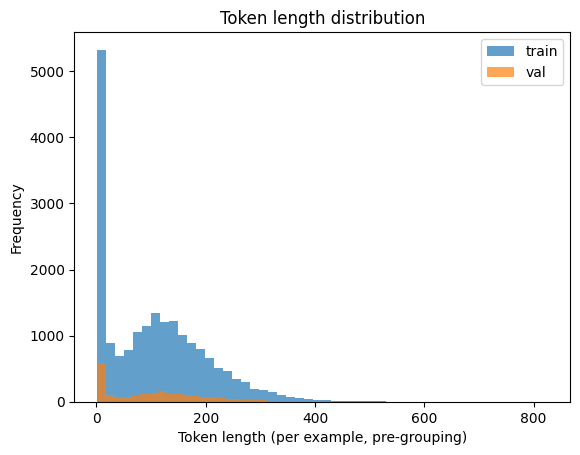

In [22]:
# Quick visualization of token length distribution

plt.hist(train_lengths, bins=50, alpha=0.7, label="train")
plt.hist(val_lengths,   bins=50, alpha=0.7, label="val")
plt.xlabel("Token length (per example, pre-grouping)")
plt.ylabel("Frequency")
plt.title("Token length distribution")
plt.legend()
plt.show()


In [23]:
# Test 1: group_texts should chunk cleanly and set labels = input_ids
def _test_group_texts():
    ex = {"input_ids": [[1,2,3,4,5,6,7,8,9,10]], "attention_mask": [[1]*10]}
    out = group_texts(ex, block_size=4)
    assert out["input_ids"][0] == [1,2,3,4] and out["labels"][0] == [1,2,3,4]
    assert len(out["input_ids"]) == len(out["labels"])
    print("Group_texts test passed")
_test_group_texts()

# Test 2: collator returns tensors with expected keys/shapes
batch = next(iter(train_loader))
assert "input_ids" in batch and "labels" in batch
assert batch["input_ids"].shape == batch["labels"].shape
print("Collator/DataLoader shape test passed:", batch["input_ids"].shape)


Group_texts test passed
Collator/DataLoader shape test passed: torch.Size([8, 128])


In [24]:
# Write a small manifest JSON that records sizes and a quick content hash.
# (Keeps it local to Colab; no Drive mount needed.)
SAVE_DIR = "/content/artifacts/wikitext2"
os.makedirs(SAVE_DIR, exist_ok=True)

def _hash_sample(ds, n=150):
    # Stable text-based hash of a small sample of input_ids
    h = hashlib.md5()
    if len(ds) == 0: return "empty"
    for r in ds.select(range(min(n, len(ds)))):
        h.update(json.dumps(r["input_ids"], separators=(",",":")).encode())
    return h.hexdigest()

manifest = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "sizes": {"train_rows": len(lm_train), "val_rows": len(lm_val)},
    "hashes": {"train_md5": _hash_sample(lm_train), "val_md5": _hash_sample(lm_val)},
    "notes": "Cleaned+deduped; split; tokenized; grouped with original lab function."
}

print(manifest)

with open(os.path.join(SAVE_DIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("Manifest saved to", os.path.join(SAVE_DIR, "manifest.json"))


{'created_at': '2025-10-29 22:54:57', 'sizes': {'train_rows': 16388, 'val_rows': 1840}, 'hashes': {'train_md5': 'ec04f47f4e2c340f27917ccca5cb7cc2', 'val_md5': 'a68e7008946ec68582cb7ab5de9627a2'}, 'notes': 'Cleaned+deduped; split; tokenized; grouped with original lab function.'}
Manifest saved to /content/artifacts/wikitext2/manifest.json


In [25]:
"""
Minimal Training Loop (Optional Enhancement)
-------------------------------------------
This is not meant to fully train GPT-2.
It simply runs one short epoch to confirm:
- data pipeline works end-to-end
- model can receive batches from DataLoader
- loss decreases slightly across steps
"""

# Load GPT-2 for causal language modeling
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to("cuda" if torch.cuda.is_available() else "cpu")

optim = AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

for step, batch in enumerate(train_loader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss

    loss.backward()
    optim.step()
    optim.zero_grad()

    if step % 50 == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")

    if step == 200:
        break

print("Training step completed.")


Step 0: loss = 4.6727
Step 50: loss = 3.8574
Step 100: loss = 3.6261
Step 150: loss = 3.6198
Step 200: loss = 3.9617
✅ Training step completed.


In [26]:
MAX_STEPS = 200  # change to None for full evaluation

model.eval()

total_loss = 0.0
total_tokens = 0
steps = 0

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss  # mean loss over tokens in the batch (per HF default)

        # Accumulate by *effective* token count to get a true token-weighted average
        # attention_mask sums == number of non-pad tokens per sequence
        if "attention_mask" in batch:
            tokens_in_batch = batch["attention_mask"].sum().item()
        else:
            # fallback: approximate by number of tokens in input_ids
            tokens_in_batch = (batch["input_ids"] != tokenizer.pad_token_id).sum().item()

        total_loss += loss.item() * tokens_in_batch
        total_tokens += tokens_in_batch
        steps += 1

        if MAX_STEPS is not None and steps >= MAX_STEPS:
            break

# Token-weighted average loss across evaluated batches
avg_loss = total_loss / max(1, total_tokens)

# Guard against overflow in exp for very large losses
avg_loss_clamped = min(avg_loss, 20.0)  # exp(20) ~ 4.85e8
perplexity = math.exp(avg_loss_clamped)

print(f"Validation avg loss (token-weighted): {avg_loss:.4f}")
print(f"Validation perplexity: {perplexity:.2f}")


Validation avg loss (token-weighted): 3.6879
Validation perplexity: 39.96
